In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
FILES_DIR = './files/'
total = pd.read_csv(FILES_DIR + 'total.csv')

In [3]:
total_df = total.copy()

In [4]:
total_df.columns

Index(['Unnamed: 0', 'session_id', 'event_timestamp', 'event_name', 'user_no',
       'item_no', 'device_type', 'operating_system_version', 'country',
       'region', 'platform', 'event_timestamp_year', 'event_timestamp_month',
       'event_timestamp_day', 'event_timestamp_hour', 'event_timestamp_minute',
       'ostype', 'osversion(number)', 'item_name', 'image_name', 'price',
       'category1_code', 'category1_name', 'category2_code', 'category2_name',
       'category3_code', 'category3_name', 'brand_no', 'brand_name',
       'birth_date', 'gender', 'age'],
      dtype='object')

In [104]:
suc_data = total_df[total_df['event_name'] == 'purchase_success'] 

In [105]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le = le.fit(suc_data['user_no'])
suc_data['user_no'] = le.transform(suc_data['user_no'])   

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_15932\2029887471.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  suc_data['user_no'] = le.transform(suc_data['user_no'])


In [106]:
suc_data = suc_data.astype({'user_no':'object'})

In [107]:
suc_data['event_timestamp'] = pd.to_datetime(suc_data['event_timestamp'])
suc_data['event_timestamp'] = suc_data['event_timestamp'].dt.strftime('%Y-%m-%d')

In [114]:
# pivot_table을 사용하여 index(세로)에는 성별(gender)과 나이(age(Group))를 넣어주고,
# Columns(가로)에는 event_name를 넣어줍니다
# 여기서 fill_value에 0을 넣어줘야, 데이터가 없을 경우 NaN이 아닌 0이 나옵니다
# 그리고 aggfunc에 len 혹은 count를 넣어주면 add_to_cart, click_item, like_item, purchase_success의 누적 개수가 나옵니다
table = pd.pivot_table(suc_data,
                       index=['event_timestamp', 'user_no'],
                       columns='event_name',
                       values='price',
                       fill_value=0,
                       aggfunc='sum')

# 이 데이터프레임의 결과를 출력합니다
table = table.reset_index()
table

event_name,event_timestamp,user_no,purchase_success
0,2021-06-03,13,77900
1,2021-06-03,36,22300
2,2021-06-03,50,55200
3,2021-06-03,53,181500
4,2021-06-03,249,24000
...,...,...,...
229921,2021-08-04,134342,33000
229922,2021-08-04,134345,57000
229923,2021-08-04,134426,332000
229924,2021-08-04,134429,335000


In [108]:
group_price = suc_data.groupby(['event_timestamp'])['price'].sum()
group_price = group_price.reset_index()

In [109]:
group_users = suc_data.groupby(['event_timestamp'])['user_no'].sum()
group_users = group_users.reset_index()

In [110]:
group_df = group_price.merge(group_users, on = ['event_timestamp'])

In [111]:
group_df['event_timestamp'] = pd.to_datetime(group_df['event_timestamp'])

In [115]:

## 전처리 과정2. 우리는 월별 데이터가 목적이기 때문에 데이터 형식을 치환
table['OrderCycle'] = table['event_timestamp']
 
## 샘플 데이터 뽑아서 확인해보기
table.sample(3)

event_name,event_timestamp,user_no,purchase_success,OrderCycle
150462,2021-07-12,63576,79000,2021-07-12
226438,2021-08-03,49545,26790,2021-08-03
1796,2021-06-03,113454,98000,2021-06-03


In [116]:
first_order = table.groupby('user_no').event_timestamp.min()
first_order

user_no
0         2021-06-15
1         2021-06-10
2         2021-07-27
3         2021-06-10
4         2021-06-29
             ...    
134736    2021-06-25
134737    2021-07-27
134738    2021-07-23
134739    2021-07-04
134740    2021-06-15
Name: event_timestamp, Length: 134741, dtype: object

In [117]:
## Data Frame의 Index를 user_no로 일시적으로 전환
table = table.set_index('user_no')
 
## 데이터 First 데이터는 Series + DF는 pandas이기에 Index 기준 자동 병합가능
table['FirstOrder'] = first_order
 
## Index의 정상화
table.reset_index(inplace = True)

In [121]:
table

event_name,user_no,event_timestamp,purchase_success,OrderCycle,FirstOrder
0,13,2021-06-03,77900,2021-06-03,2021-06-03
1,36,2021-06-03,22300,2021-06-03,2021-06-03
2,50,2021-06-03,55200,2021-06-03,2021-06-03
3,53,2021-06-03,181500,2021-06-03,2021-06-03
4,249,2021-06-03,24000,2021-06-03,2021-06-03
...,...,...,...,...,...
229921,134342,2021-08-04,33000,2021-08-04,2021-06-03
229922,134345,2021-08-04,57000,2021-08-04,2021-08-04
229923,134426,2021-08-04,332000,2021-08-04,2021-06-19
229924,134429,2021-08-04,335000,2021-08-04,2021-06-07


In [122]:
## 주기별 구매 User 계산
co1 = table.groupby(['FirstOrder', 'OrderCycle']).user_no.nunique()
co1 = co1.reset_index()
co1.rename({'user_no': 'TotalUsers'}, axis = 1, inplace = True)
 
 
 
## 주기별 구매 금액 계산
co2 = table.groupby(['FirstOrder', 'OrderCycle']).purchase_success.sum()
co2 = co2.reset_index()
co2.rename({'purchase_success': 'PurchaseAmnt'}, axis = 1, inplace = True)
 
 
## 데이터의 병합
co = co1.merge(co2, on = ['FirstOrder', 'OrderCycle'])
co.head()

,FirstOrder,OrderCycle,TotalUsers,PurchaseAmnt
0,2021-06-03,2021-06-03,2206,230374319
1,2021-06-03,2021-06-04,95,10654000
2,2021-06-03,2021-06-05,82,11671500
3,2021-06-03,2021-06-06,96,15910800
4,2021-06-03,2021-06-07,125,15649460


In [123]:
from ipypb import ipb
temp = []
 
for i in ipb(range(co.shape[0])):
    f_first_order = pd.to_datetime(co.FirstOrder[i]).to_period('W')
    f_order_cycle = pd.to_datetime(co.OrderCycle[i]).to_period('W')
    
    month_diff = (f_order_cycle - f_first_order).n
    
    temp.append(month_diff)
co['CohortPeriod'] = temp


 [████████████████████████████████████████████████████████████] 2016/2016 [00:01<00:00, 0.00s/it]

In [124]:
co.sample(10)

,FirstOrder,OrderCycle,TotalUsers,PurchaseAmnt,CohortPeriod
149,2021-06-05,2021-06-29,78,7597040,4
802,2021-06-17,2021-06-28,61,7617600,2
1600,2021-07-07,2021-07-26,20,1059100,3
328,2021-06-08,2021-07-01,123,16691030,3
820,2021-06-17,2021-07-16,43,4741700,4
453,2021-06-10,2021-07-13,97,11765000,5
582,2021-06-12,2021-08-02,50,5215200,8
403,2021-06-09,2021-07-19,72,7015720,6
719,2021-06-15,2021-07-14,92,10449830,4
1776,2021-07-14,2021-07-27,20,1291200,2


In [140]:
# pivot_table_co을 사용하여 index(세로)에는 성별(gender)과 나이(age(Group))를 넣어주고,
# Columns(가로)에는 event_name를 넣어줍니다
# 여기서 fill_value에 0을 넣어줘야, 데이터가 없을 경우 NaN이 아닌 0이 나옵니다
# 그리고 aggfunc에 len 혹은 count를 넣어주면 add_to_cart, click_item, like_item, purchase_success의 누적 개수가 나옵니다
table_co = pd.pivot_table(co,
                       index=['FirstOrder', 'TotalUsers'],
                    #    columns='TotalUsers',
                       values='CohortPeriod',
                       fill_value=0,
                       aggfunc='sum')

# 이 데이터프레임의 결과를 출력합니다
table_co = table_co.reset_index()
table_co

,FirstOrder,TotalUsers,CohortPeriod
0,2021-06-03,26,9
1,2021-06-03,34,1
2,2021-06-03,37,3
3,2021-06-03,38,8
4,2021-06-03,43,8
...,...,...,...
1410,2021-08-02,43,0
1411,2021-08-02,1285,0
1412,2021-08-03,24,0
1413,2021-08-03,1331,0


In [159]:
group_users = co.groupby(['FirstOrder'])['CohortPeriod', 'TotalUsers','PurchaseAmnt'].sum()
group_users = pd.DataFrame(group_users)
group_users = group_users.reset_index()

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_15932\458527599.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  group_users = co.groupby(['FirstOrder'])['CohortPeriod', 'TotalUsers','PurchaseAmnt'].sum()


In [160]:
group_users

,FirstOrder,CohortPeriod,TotalUsers,PurchaseAmnt
0,2021-06-03,279,6458,758106597
1,2021-06-04,279,8926,1088721970
2,2021-06-05,279,7354,877007405
3,2021-06-06,279,9650,1182425788
4,2021-06-07,220,10346,1244013849
...,...,...,...,...
58,2021-07-31,3,1044,114717060
59,2021-08-01,3,1349,148546680
60,2021-08-02,0,1340,142959989
61,2021-08-03,0,1355,141811590


In [165]:
co_retention = co.set_index(['FirstOrder', 'CohortPeriod'])
# co_retention = group_users
co_retention = co_retention.TotalUsers.unstack(1)
retention = co_retention.div(co_retention[0],axis = 0)

ValueError: Index contains duplicate entries, cannot reshape

In [162]:
co_purchase = group_users.set_index(['FirstOrder', 'CohortPeriod'])
co_purchase = co_purchase.PurchaseAmnt.unstack(1)

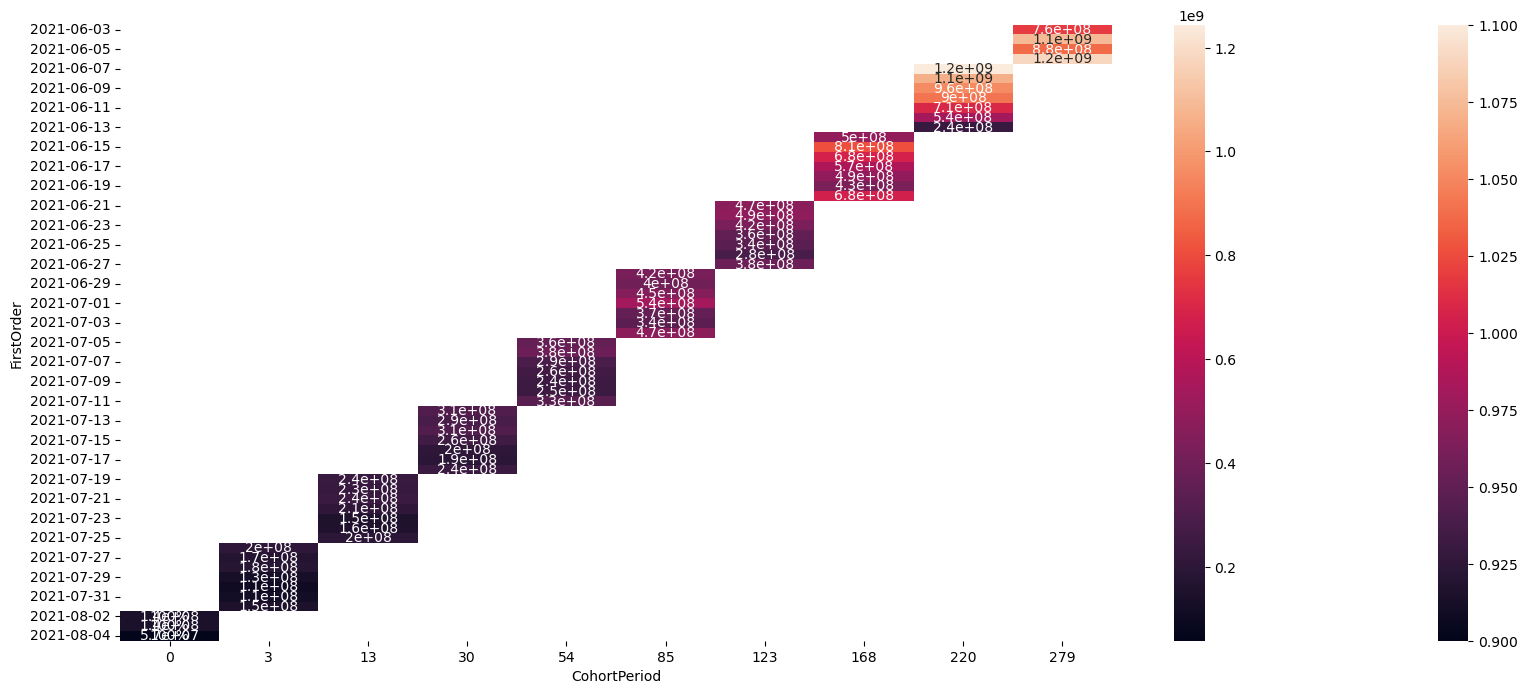

In [164]:
import matplotlib.pyplot as plt
import seaborn as sns
 
## 재방문율 시각화 진행
plt.rcParams['figure.figsize'] = (20, 8)
sns.heatmap(retention, annot = True, fmt = '.0%')
 
## 구매 규모 시각화 
plt.rcParams['figure.figsize'] = (20, 12)
sns.heatmap(co_purchase, annot = True
           # , fmt = '.0%'
           )
 
plt.yticks(rotation = 360);